# MLP
Mean RCI over 14 cell lines.

This notebook uses
lncRNA, canonical, no middle-exclusion train, no middle-exclusion test, -1 threshold, learning module, cross-validation.

In [1]:
SEED = 43
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-04-29 16:11:02.266919


In [2]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP'
SAVE_DESCRIM_FILENAME = None # 'GMM'
LOAD_MODEL_FILENAME = None # 'MLP.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM.0.0.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = -1  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -2   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         = 0    #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [6]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-04-29 16:11:06.075922
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 4372
Num RCI: 4372
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4372 sequences.

Training # 1 1
2023-04-29 16:11:15.648932
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1810:1687 51.76%
Computed class weights: {0: 1.0364552459988146, 1: 0.9660220994475138}
Valid 1:0 433:442 49.49%
FIT


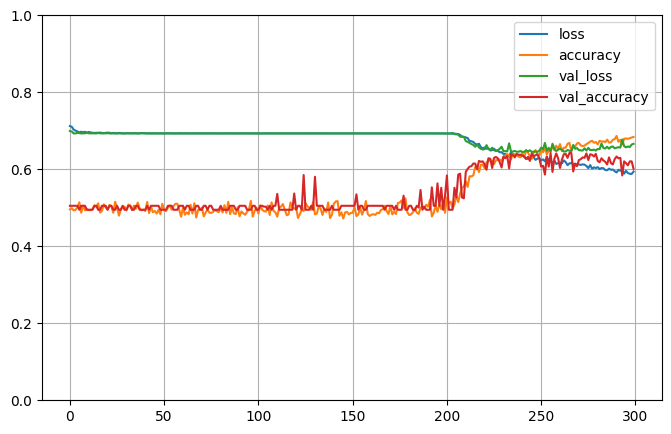


Testing # 1 1
2023-04-29 16:14:39.224934
PREDICT
Test 1:0 433:442 49.49%
Predict 1:0 590:285 67.43%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5672414 mean 0.18599507 std
Range of scores: 0.0050216215 to 0.9042196
Score threshold 0.5
Confusion matrix
 [[189 253]
 [ 96 337]]
Normalized matrix
 [[0.216      0.28914286]
 [0.10971429 0.38514286]]
Extreme scores correct, pos:neg 215 89
Extreme scores incorrect pos:neg 111 36


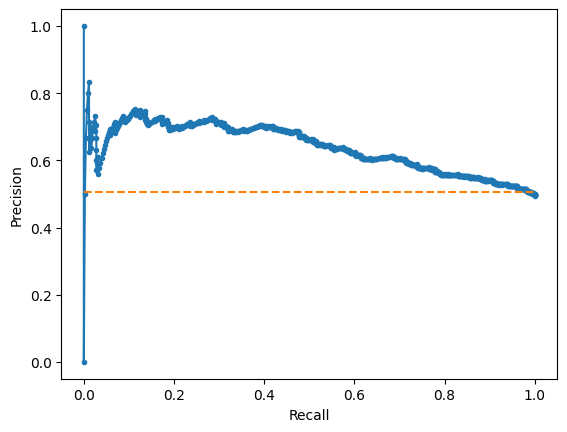

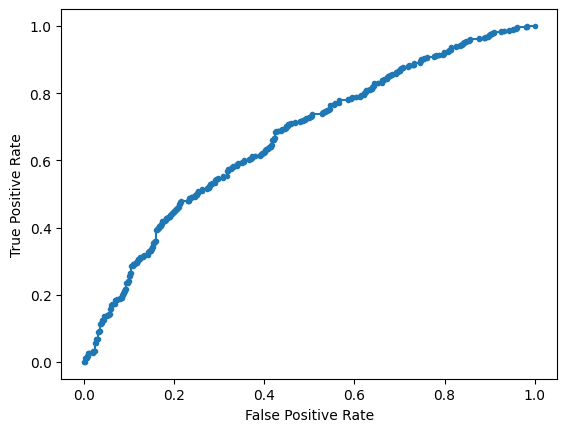

Accuracy: 60.11% Precision: 57.12% Recall: 77.83%
F1: 65.88% MCC: 0.2197
AUPRC: 63.86% AUROC: 66.83%
 accuracy [60.11428571428571]
 precision [57.11864406779661]
 recall [77.82909930715935]
 F1 [65.88465298142717]
 MCC [0.2196583986372949]
 AUPRC [63.858072451441515]
 AUROC [66.83247468466868]

Training # 1 2
2023-04-29 16:14:39.975397
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1789:1708 51.16%
Computed class weights: {0: 1.023711943793911, 1: 0.9773616545556176}
Valid 1:0 454:421 51.89%
FIT


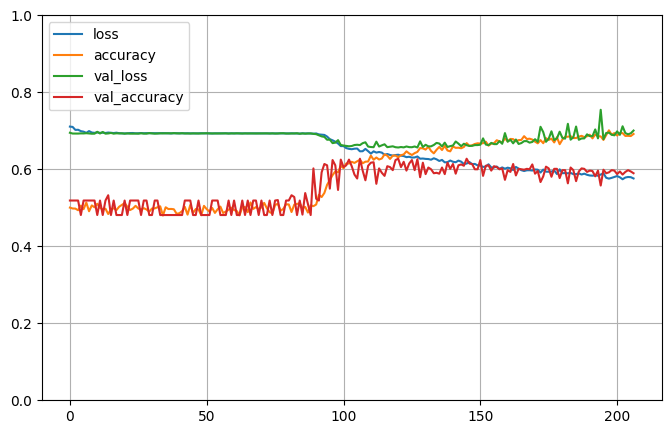


Testing # 1 2
2023-04-29 16:17:03.329174
PREDICT
Test 1:0 454:421 51.89%
Predict 1:0 626:249 71.54%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.56734025 mean 0.122128844 std
Range of scores: 0.18220776 to 0.8582574
Score threshold 0.5
Confusion matrix
 [[172 249]
 [ 77 377]]
Normalized matrix
 [[0.19657143 0.28457143]
 [0.088      0.43085714]]
Extreme scores correct, pos:neg 147 30
Extreme scores incorrect pos:neg 77 5


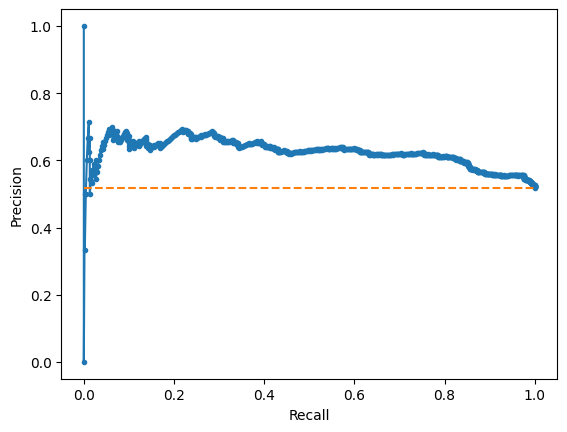

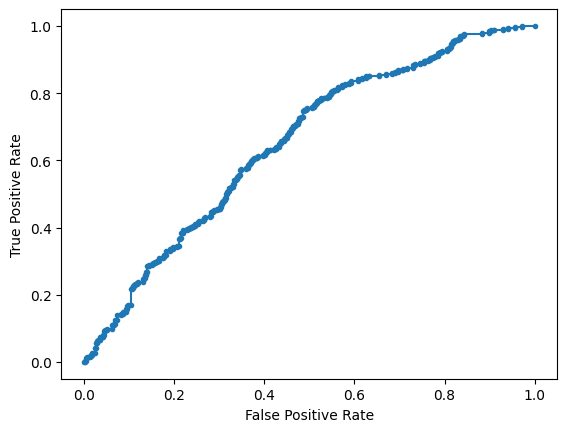

Accuracy: 62.74% Precision: 60.22% Recall: 83.04%
F1: 69.81% MCC: 0.2646
AUPRC: 62.46% AUROC: 65.11%
 accuracy [62.74285714285715]
 precision [60.22364217252396]
 recall [83.03964757709251]
 F1 [69.81481481481481]
 MCC [0.2645968723957594]
 AUPRC [62.462412359592555]
 AUROC [65.1051095043268]

Training # 1 3
2023-04-29 16:17:04.329309
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1810:1688 51.74%
Computed class weights: {0: 1.036137440758294, 1: 0.9662983425414364}
Valid 1:0 433:441 49.54%
FIT


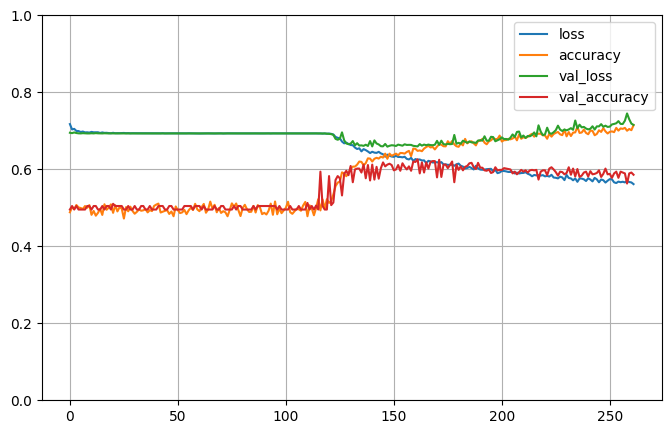


Testing # 1 3
2023-04-29 16:20:27.708379
PREDICT
Test 1:0 433:441 49.54%
Predict 1:0 480:394 54.92%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.51108664 mean 0.14687589 std
Range of scores: 0.049891416 to 0.8514563
Score threshold 0.5
Confusion matrix
 [[254 187]
 [140 293]]
Normalized matrix
 [[0.29061785 0.21395881]
 [0.16018307 0.33524027]]
Extreme scores correct, pos:neg 101 86
Extreme scores incorrect pos:neg 54 35


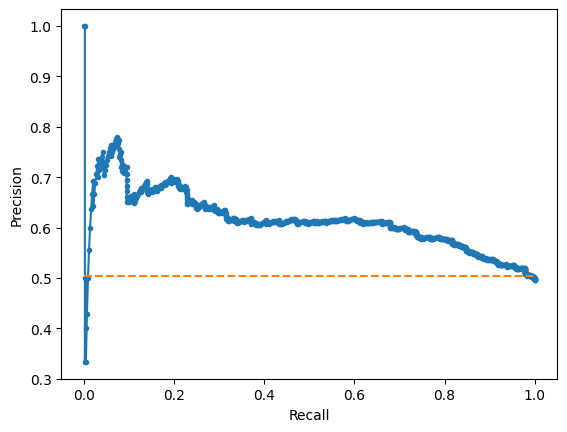

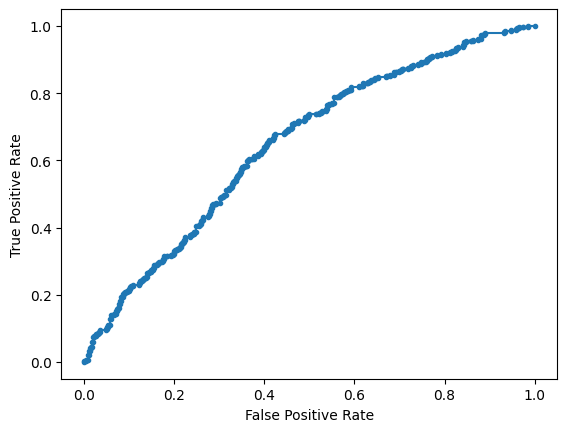

Accuracy: 62.59% Precision: 61.04% Recall: 67.67%
F1: 64.18% MCC: 0.2539
AUPRC: 61.40% AUROC: 64.81%
 accuracy [62.58581235697941]
 precision [61.04166666666667]
 recall [67.6674364896074]
 F1 [64.18400876232202]
 MCC [0.2538594482635531]
 AUPRC [61.40293632729378]
 AUROC [64.81175996187544]

Training # 1 4
2023-04-29 16:20:28.355389
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1778:1720 50.83%
Computed class weights: {0: 1.0168604651162791, 1: 0.9836895388076491}
Valid 1:0 465:409 53.20%
FIT


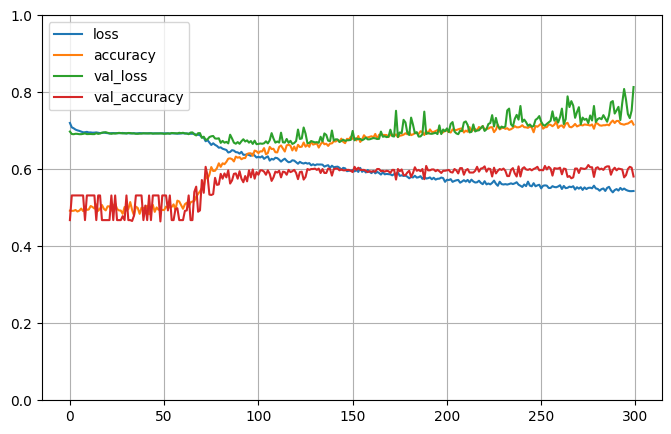


Testing # 1 4
2023-04-29 16:23:51.767200
PREDICT
Test 1:0 465:409 53.20%
Predict 1:0 373:501 42.68%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.43167865 mean 0.26520002 std
Range of scores: 0.00012732562 to 0.91309035
Score threshold 0.5
Confusion matrix
 [[272 137]
 [229 236]]
Normalized matrix
 [[0.31121281 0.15675057]
 [0.26201373 0.27002288]]
Extreme scores correct, pos:neg 149 205
Extreme scores incorrect pos:neg 82 144


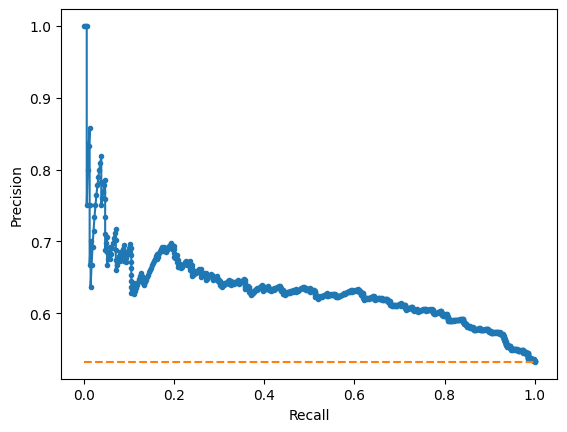

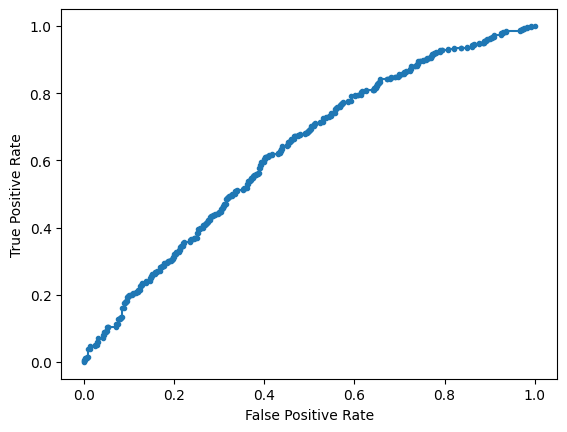

Accuracy: 58.12% Precision: 63.27% Recall: 50.75%
F1: 56.32% MCC: 0.1741
AUPRC: 63.24% AUROC: 62.80%
 accuracy [58.12356979405035]
 precision [63.27077747989276]
 recall [50.752688172043015]
 F1 [56.324582338902154]
 MCC [0.1740860352996219]
 AUPRC [63.2394987518669]
 AUROC [62.79885374766674]

Training # 1 5
2023-04-29 16:23:52.368395
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1785:1713 51.03%
Computed class weights: {0: 1.021015761821366, 1: 0.9798319327731092}
Valid 1:0 458:416 52.40%
FIT


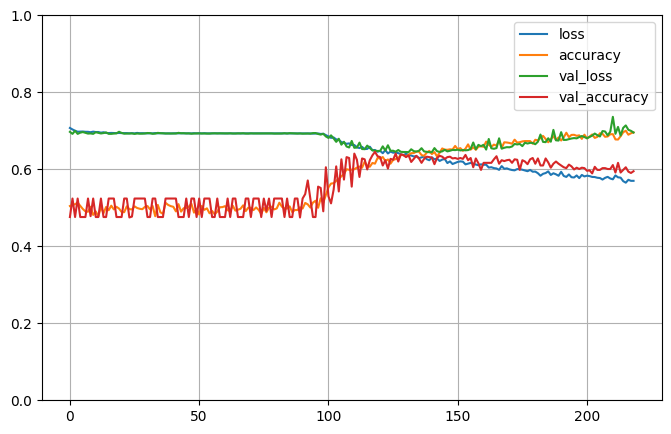


Testing # 1 5
2023-04-29 16:26:16.295524
PREDICT
Test 1:0 458:416 52.40%
Predict 1:0 480:394 54.92%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.52468604 mean 0.12343711 std
Range of scores: 0.19131736 to 0.879935
Score threshold 0.5
Confusion matrix
 [[250 166]
 [144 314]]
Normalized matrix
 [[0.28604119 0.18993135]
 [0.16475973 0.35926773]]
Extreme scores correct, pos:neg 99 49
Extreme scores incorrect pos:neg 46 11


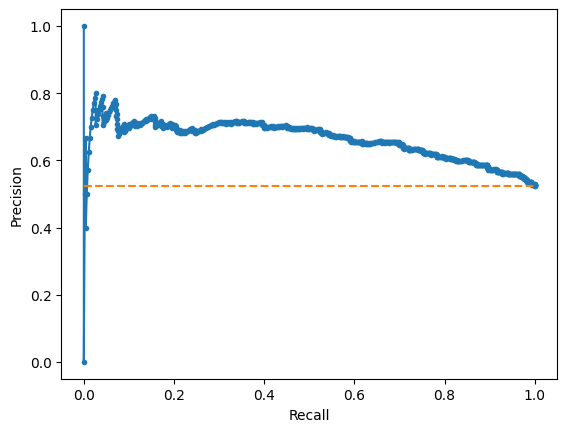

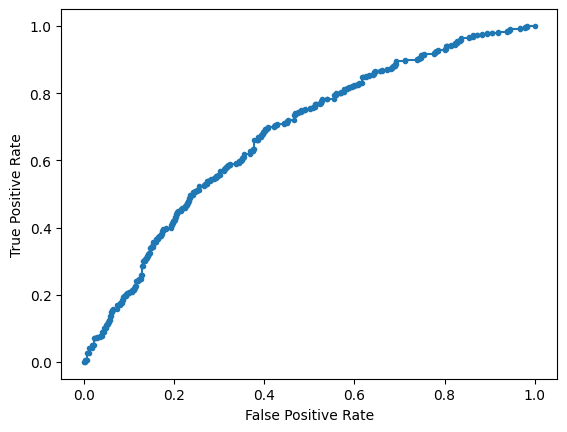

Accuracy: 64.53% Precision: 65.42% Recall: 68.56%
F1: 66.95% MCC: 0.2876
AUPRC: 66.23% AUROC: 67.79%
 accuracy [64.53089244851259]
 precision [65.41666666666667]
 recall [68.5589519650655]
 F1 [66.95095948827291]
 MCC [0.2876157676201008]
 AUPRC [66.23303063232626]
 AUROC [67.79318525361103]

Training # 2 1
2023-04-29 16:26:16.941538
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1807:1690 51.67%
Computed class weights: {0: 1.0346153846153847, 1: 0.9676258992805755}
Valid 1:0 436:439 49.83%
FIT


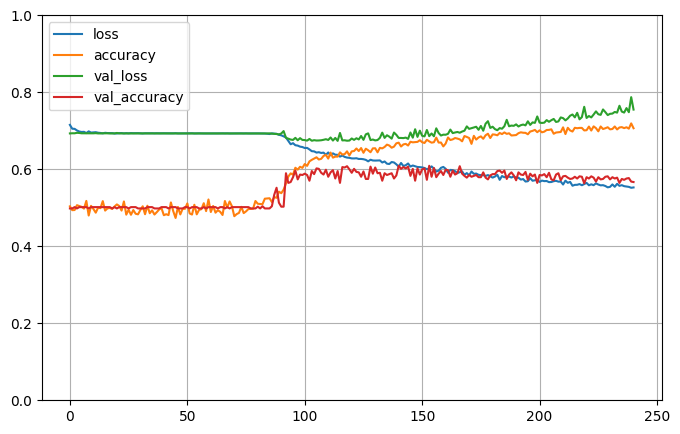


Testing # 2 1
2023-04-29 16:29:40.433302
PREDICT
Test 1:0 436:439 49.83%
Predict 1:0 434:441 49.60%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.4956572 mean 0.17727113 std
Range of scores: 0.024638372 to 0.8894182
Score threshold 0.5
Confusion matrix
 [[269 170]
 [172 264]]
Normalized matrix
 [[0.30742857 0.19428571]
 [0.19657143 0.30171429]]
Extreme scores correct, pos:neg 115 127
Extreme scores incorrect pos:neg 67 69


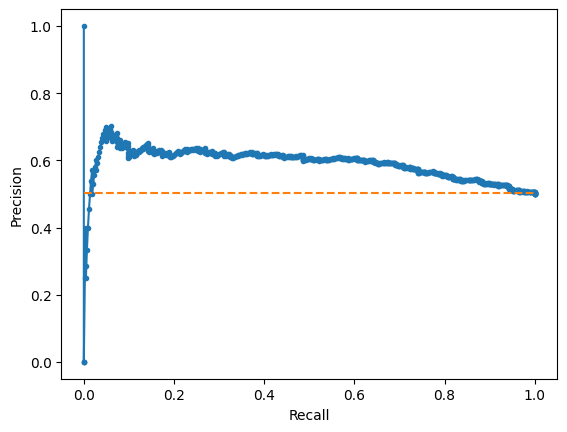

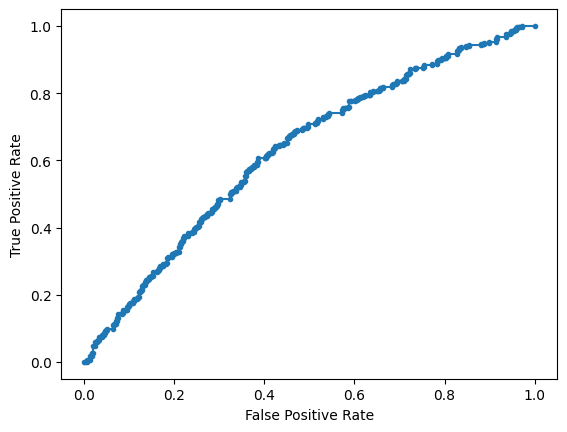

Accuracy: 60.91% Precision: 60.83% Recall: 60.55%
F1: 60.69% MCC: 0.2183
AUPRC: 59.03% AUROC: 62.72%
 accuracy [60.91428571428571]
 precision [60.82949308755761]
 recall [60.550458715596335]
 F1 [60.6896551724138]
 MCC [0.2182665531912637]
 AUPRC [59.03081355254904]
 AUROC [62.7202148335458]

Training # 2 2
2023-04-29 16:29:41.049065
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1794:1703 51.30%
Computed class weights: {0: 1.0267175572519085, 1: 0.9746376811594203}
Valid 1:0 449:426 51.31%
FIT


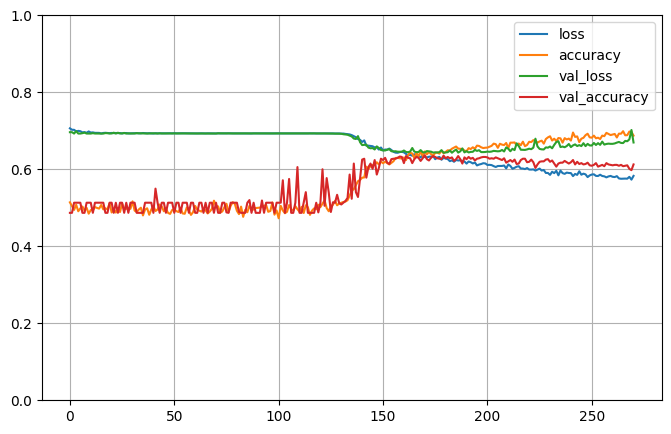


Testing # 2 2
2023-04-29 16:33:04.640485
PREDICT
Test 1:0 449:426 51.31%
Predict 1:0 521:354 59.54%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.52587974 mean 0.15063818 std
Range of scores: 0.06014204 to 0.83524376
Score threshold 0.5
Confusion matrix
 [[231 195]
 [123 326]]
Normalized matrix
 [[0.264      0.22285714]
 [0.14057143 0.37257143]]
Extreme scores correct, pos:neg 128 94
Extreme scores incorrect pos:neg 65 20


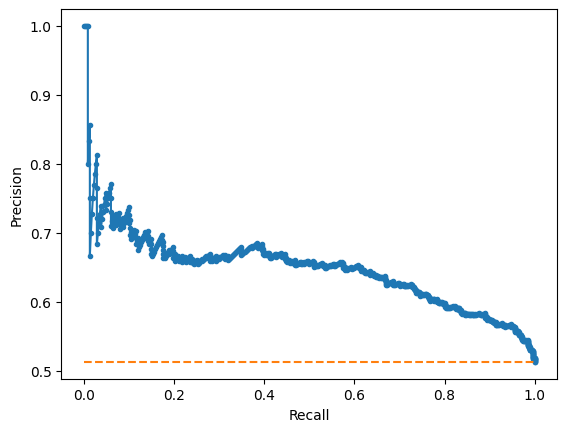

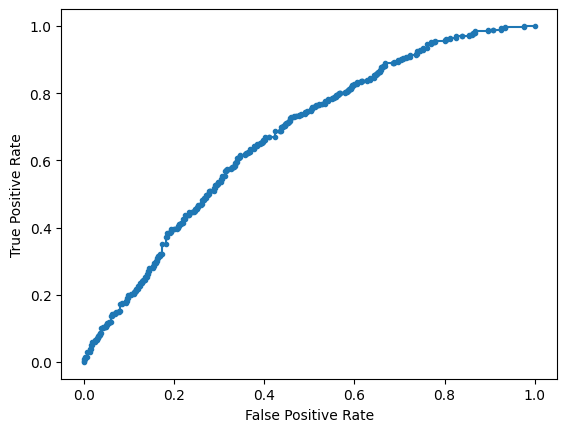

Accuracy: 63.66% Precision: 62.57% Recall: 72.61%
F1: 67.22% MCC: 0.2732
AUPRC: 64.86% AUROC: 67.14%
 accuracy [63.65714285714286]
 precision [62.571976967370446]
 recall [72.60579064587974]
 F1 [67.21649484536083]
 MCC [0.27324149156371597]
 AUPRC [64.8556047557683]
 AUROC [67.1351046143229]

Training # 2 3
2023-04-29 16:33:05.774774
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1771:1727 50.63%
Computed class weights: {0: 1.0127388535031847, 1: 0.9875776397515528}
Valid 1:0 472:402 54.00%
FIT


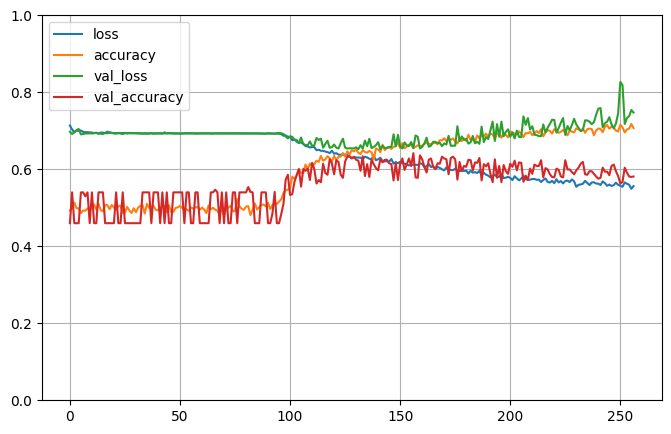


Testing # 2 3
2023-04-29 16:36:30.570112
PREDICT
Test 1:0 472:402 54.00%
Predict 1:0 561:313 64.19%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.54589635 mean 0.17393029 std
Range of scores: 0.041825667 to 0.83356243
Score threshold 0.5
Confusion matrix
 [[201 201]
 [112 360]]
Normalized matrix
 [[0.22997712 0.22997712]
 [0.12814645 0.41189931]]
Extreme scores correct, pos:neg 191 93
Extreme scores incorrect pos:neg 101 38


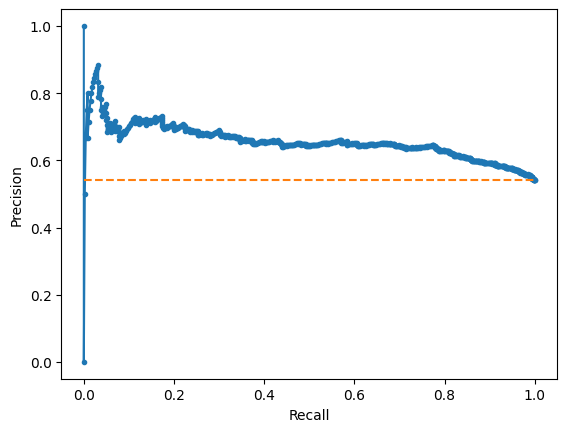

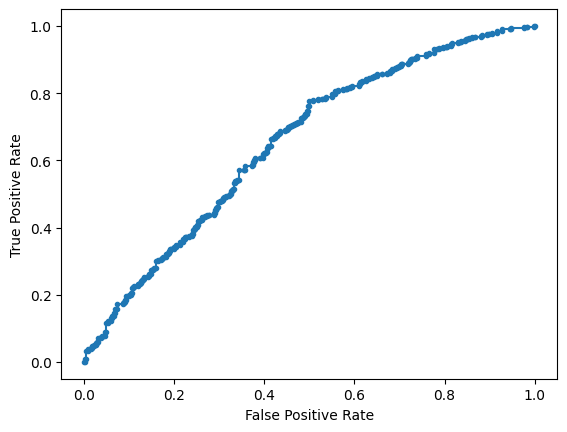

Accuracy: 64.19% Precision: 64.17% Recall: 76.27%
F1: 69.70% MCC: 0.2731
AUPRC: 65.52% AUROC: 65.30%
 accuracy [64.18764302059496]
 precision [64.1711229946524]
 recall [76.27118644067797]
 F1 [69.6999031945789]
 MCC [0.2730927136780013]
 AUPRC [65.52027988001751]
 AUROC [65.29587233324901]

Training # 2 4
2023-04-29 16:36:31.516221
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1816:1682 51.92%
Computed class weights: {0: 1.039833531510107, 1: 0.9631057268722467}
Valid 1:0 427:447 48.86%
FIT


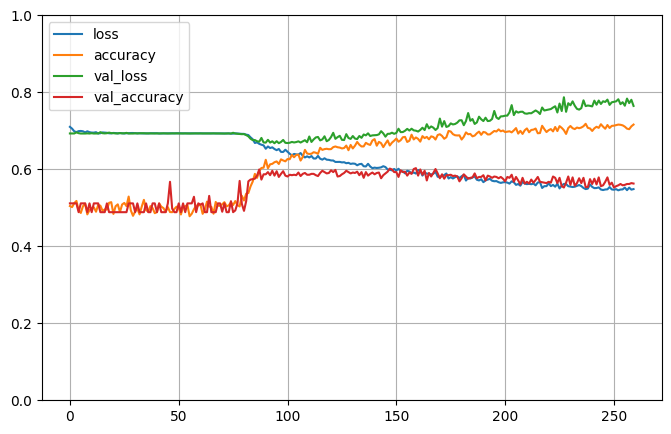


Testing # 2 4
2023-04-29 16:39:55.422417
PREDICT
Test 1:0 427:447 48.86%
Predict 1:0 430:444 49.20%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.49268526 mean 0.20539975 std
Range of scores: 0.045380626 to 0.9185451
Score threshold 0.5
Confusion matrix
 [[272 175]
 [172 255]]
Normalized matrix
 [[0.31121281 0.20022883]
 [0.19679634 0.29176201]]
Extreme scores correct, pos:neg 136 144
Extreme scores incorrect pos:neg 85 78


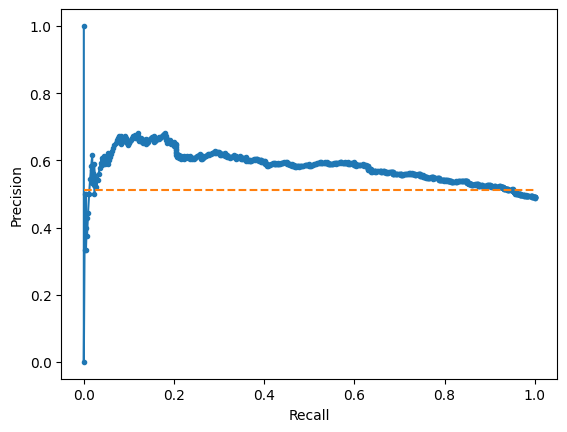

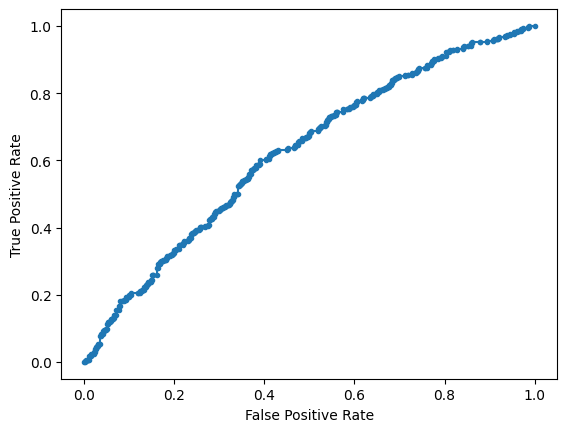

Accuracy: 60.30% Precision: 59.30% Recall: 59.72%
F1: 59.51% MCC: 0.2057
AUPRC: 58.13% AUROC: 62.24%
 accuracy [60.297482837528605]
 precision [59.30232558139535]
 recall [59.71896955503513]
 F1 [59.509918319719944]
 MCC [0.20566333943764112]
 AUPRC [58.13063043456788]
 AUROC [62.2432139320686]

Training # 2 5
2023-04-29 16:39:56.058613
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1784:1714 51.00%
Computed class weights: {0: 1.0204200700116686, 1: 0.9803811659192825}
Valid 1:0 459:415 52.52%
FIT


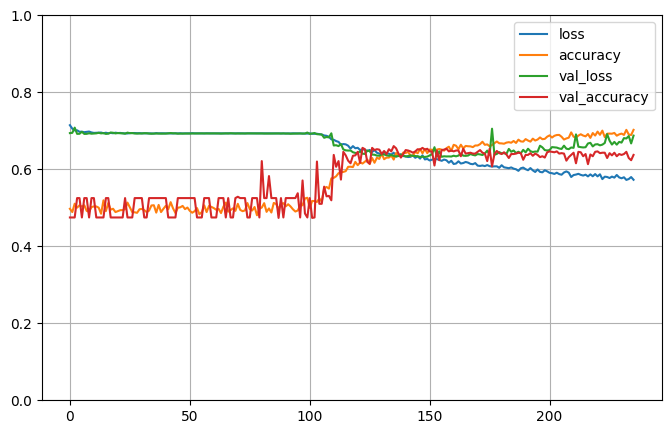


Testing # 2 5
2023-04-29 16:43:19.670929
PREDICT
Test 1:0 459:415 52.52%
Predict 1:0 500:374 57.21%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.51575226 mean 0.13500215 std
Range of scores: 0.06313813 to 0.79061276
Score threshold 0.5
Confusion matrix
 [[246 169]
 [128 331]]
Normalized matrix
 [[0.28146453 0.19336384]
 [0.14645309 0.37871854]]
Extreme scores correct, pos:neg 115 78
Extreme scores incorrect pos:neg 35 28


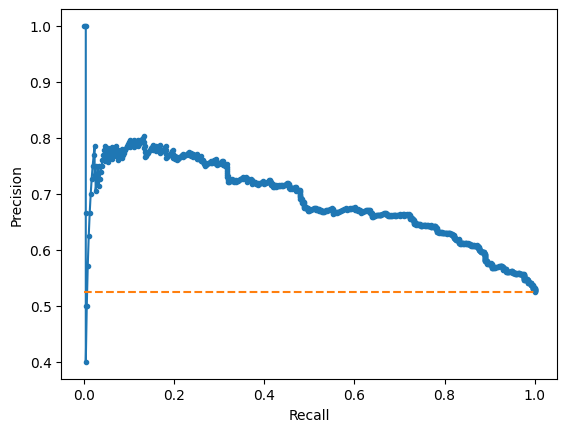

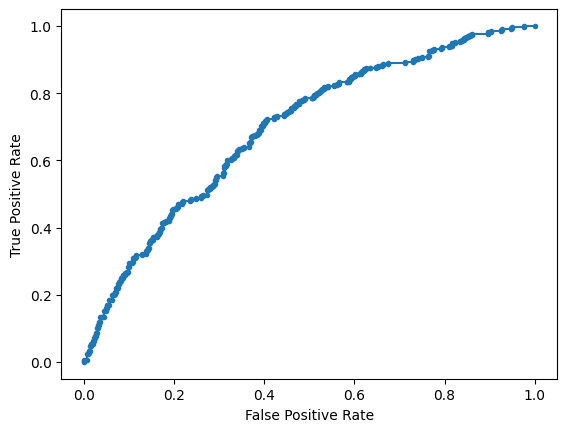

Accuracy: 66.02% Precision: 66.20% Recall: 72.11%
F1: 69.03% MCC: 0.3168
AUPRC: 68.87% AUROC: 69.47%
 accuracy [66.01830663615561]
 precision [66.2]
 recall [72.1132897603486]
 F1 [69.03023983315954]
 MCC [0.3168154939373573]
 AUPRC [68.8657307509661]
 AUROC [69.47266188938762]
2023-04-29 16:43:20.288475


In [7]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [8]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 62.32% std 2.42
 precision mean 62.01% std 2.84
 recall mean 68.91% std 9.68
 F1 mean 64.93% std 4.66
 MCC mean 0.2487 std 0.0432
 AUPRC mean 63.36% std 3.27
 AUROC mean 65.42% std 2.40
 accuracy [[60.11428571428571], [62.74285714285715], [62.58581235697941], [58.12356979405035], [64.53089244851259], [60.91428571428571], [63.65714285714286], [64.18764302059496], [60.297482837528605], [66.01830663615561]]
 precision [[57.11864406779661], [60.22364217252396], [61.04166666666667], [63.27077747989276], [65.41666666666667], [60.82949308755761], [62.571976967370446], [64.1711229946524], [59.30232558139535], [66.2]]
 recall [[77.82909930715935], [83.03964757709251], [67.6674364896074], [50.752688172043015], [68.5589519650655], [60.550458715596335], [72.60579064587974], [76.27118644067797], [59.71896955503513], [72.1132897603486]]
 F1 [[65.88465298142717], [69.81481481481481], [64.18400876232202], [56.324582338902154], [66.95095948827291], [60.6896551724138], [67.21649484536083]